In [1]:
import pickle
from pylab import *
import matplotlib.image as mpimg
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import orgSimData as osd

In [2]:
with open('/data/chocula/villaa/PhotoN_SuperSim/ZipSum/PN0x0004_capReplace_condensed_small.pkl','rb') as readFile:
      data=pickle.load(readFile,encoding='latin1')

print(data['z14']['ybe'].keys())
infodata = osd.getFirstData_Simv4(False,False)

dict_keys(['totalevents', 'NRedep', 'cEscape', 'ncap', 'NRhit', 'ERhit'])


In [3]:
#got smarter about the mpl config: see mplstyles/ directory
print(axis_font)
print(title_font)
print(legend_font)
print(mpl.rcParams['ytick.labelsize']) #should be 22 in my style
plt.style.use('standard')
print(mpl.rcParams['ytick.labelsize']) #should be 22 in my style

{'fontname': 'Arial', 'size': '32'}
{'fontname': 'Arial', 'size': '16', 'color': 'black', 'weight': 'normal', 'verticalalignment': 'bottom'}
{'fontname': 'Arial', 'size': '22'}
medium
22.0


In [4]:
#adding the yield [Lindhard]
import lindhard as lind #custom library in lindhard.py
import pnRes as pnr #custom library in pnRes.py, for PN resolution computation

#=================change this stuff to get plots for different detectors=============
zip='z14'
set='ybe'
type='smalldata'
#===================================================================================

capdata = data[zip][set]

#try to set up lindhard calc for many k's
klind = np.arange(0.1,0.25,0.025)
flind = [] #for the Lindhard callables to go with klind
for k in klind:
  par = lind.getLindhardPars('Ge')
  par['k'] = k #crazy high value jus to see
  y = lind.getLindhard(par,False) #get standard Lindhard yiedl
  flind.append(np.vectorize(y)) #get standard Lindhard yiedl)



#voltage and average energy per pair
V=infodata[zip][set]['CDMSliteV'] #detector Voltage
egam = 3.3 #eV per pair

#make copies of the capdata['NRedep'] object
NRedep_shape = (np.shape(klind)[0],np.shape(capdata['NRedep'])[0],np.shape(capdata['NRedep'])[1])
NRedep_ee_all = np.zeros(NRedep_shape,dtype=float)
NRedep_all = np.zeros(NRedep_shape,dtype=float)

for ind,k in enumerate(klind):
    print('{}\t{}'.format(ind,k))
    NRedep_all[ind] = capdata['NRedep']
    NRedep_ee_all[ind] = capdata['NRedep']*flind[ind](capdata['NRedep'])


NRedep_t = NRedep_all + (V/egam)*NRedep_ee_all #convert to total energy
edepNR_t = np.sum(NRedep_t,2) #sum the individual hits

#convert back to experimental electron-equivalent scale for application
#of resolution, this is electron-equivalent energy with the ER assumption
edepNR_ee = edepNR_t/(1+(V/egam)) 
print(np.shape(edepNR_ee))

0	0.1
1	0.125
2	0.15
3	0.175
4	0.19999999999999998
5	0.22499999999999998
(6, 39185)


In [5]:
#add in the resolution from a model
import pnRes as pnr #custom library in pnRes.py, for PN resolution computation 

r = pnr.getRes(zip) #select the default mode (CDMSlite-70V) for the resolution model by not specifying second param
rv =  np.vectorize(r)

#apply the res
edepNR_ee_res = edepNR_ee + np.random.normal(0,rv(edepNR_ee))
edepNR_t_res = (1+(V/egam))*edepNR_ee_res  #convert back to eVt if desired

In [6]:
#figure out the contribution as a function of k at threshold

thresh_t = infodata[zip][set]['CDMSlite']['thresh_t']
sigthr_t = infodata[zip][set]['CDMSlite']['sigthr_t']
tvec = [thresh_t,2500] #vector of thresholds to compute stuff at
if (zip=='z4'):
  tvec = [thresh_t,1300]

cap_contrib = np.zeros((2,np.shape(klind)[0]),dtype=double)
cap_contrib_x = np.zeros((2,np.shape(klind)[0]),dtype=double)
cap_contrib_yerr = np.zeros((2,np.shape(klind)[0]),dtype=double)
cap_contrib_xerr = np.zeros((2,np.shape(klind)[0]),dtype=double)

for ind,k in enumerate(klind):
    cCap = capdata['ncap']>0
    for ind1,thr in enumerate(tvec):
      cInRange = (edepNR_t_res[ind]<thr+sigthr_t) & (edepNR_t_res[ind]>thr-sigthr_t)
      capn = np.shape(edepNR_t_res[ind][cInRange&cCap])[0]
      n = np.shape(edepNR_t_res[ind][cInRange])[0]
      perc = np.double(capn)/np.double(n)
      cap_contrib[ind1][ind] = perc
      cap_contrib_x[ind1][ind] = thresh_t
      cap_contrib_yerr[ind1][ind] = np.sqrt(perc*(1-perc)/np.float(n))
      cap_contrib_xerr[ind1][ind] = sigthr_t


print(cap_contrib)

[[ 0.13705584  0.18061674  0.34024896  0.39130435  0.45031056  0.5528169 ]
 [ 0.00613497  0.04375     0.09210526  0.17021277  0.12418301  0.15882353]]


In [7]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

#lay out the colors
rgb_r = (255/255.0,0/255.0,0/255.0)
rgb_b = (0/255.0,0/255.0,255/255.0)
rgb_o = (255/255.0,127/255.0,0/255.0)
rgb_b = (31/255.0,120/255.0,180/255.0)
rgb_lr = (251/255.0,154/255.0,153/255.0)
rgb_g = (203/255.0,195/255.0,195/255.0)


pointlabel='{0} {1} capture contribution at trigger\n threshold ({2:1.2f} keV$_t$)'.format(infodata[zip]['detname'] \
            ,infodata[zip][set]['typelabel'],thresh_t/1000)
otherpointlabel='contribution at {0:1.2f} keV$_t$' \
             .format(tvec[1]/1000)

ax1.errorbar(klind, cap_contrib[0]*100, yerr=cap_contrib_yerr[0]*100,marker='o', \
             markersize=8, linestyle='none',color='k', label=pointlabel)
ax1.errorbar(klind, cap_contrib[1]*100, yerr=cap_contrib_yerr[1]*100,marker='v', \
             markersize=8, linestyle='none',color='r', label=otherpointlabel)



ymin = 0.0
ymax = 100.0
if (zip=='z4'):
  ymax=20


#ax1.set_yscale('log')
ax1.set_xlim(np.min(klind)-0.05, np.max(klind)+0.05) #in keV
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel('Lindhard parameter \"k\"',**axis_font)
ax1.set_ylabel('capture contribution [%]',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
#ax1.legend([gh,gl,nh,nl], ['gamma (high gain)','gamma (low gain)','neutron (high gain)', 'neutron (low gain)'],loc=1)
#ax1.legend(loc=1, bbox_to_anchor=(0.82, 1),
#         fancybox=True, shadow=True, ncol=4)
ax1.legend(loc=1,prop={'size':22})

In [8]:
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

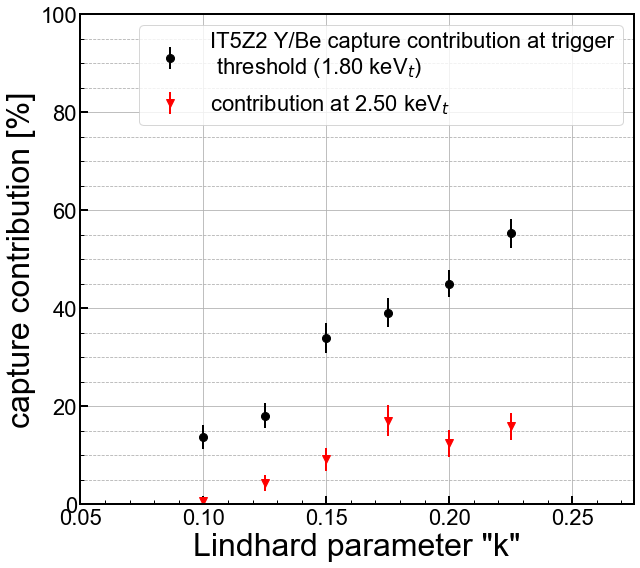

In [9]:
plt.tight_layout()
plt.savefig('figures/{0}_{1}_CapContribLind_{2}.png'.format(zip,set,'CDMSlite'))
plt.show()